## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 10 
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

"""
建立實驗組合
"""
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = "exp-optim-%s-reduce_factor-%s-reduce_patient-%s" % (str(optim), str(reduce_factor),str(reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

50000/50000 [==============================] - 10s 198us/step - loss: 1.5012 - accuracy: 0.4755 - val_loss: 1.6489 - val_accuracy: 0.4097
Epoch 6/10
50000/50000 [==============================] - 10s 191us/step - loss: 1.4573 - accuracy: 0.4922 - val_loss: 1.5842 - val_accuracy: 0.4358
Epoch 7/10
50000/50000 [==============================] - 10s 201us/step - loss: 1.4204 - accuracy: 0.5039 - val_loss: 1.5526 - val_accuracy: 0.4418
Epoch 8/10
50000/50000 [==============================] - 10s 198us/step - loss: 1.3905 - accuracy: 0.5151 - val_loss: 1.5355 - val_accuracy: 0.4478
Epoch 9/10
50000/50000 [==============================] - 10s 206us/step - loss: 1.3593 - accuracy: 0.5260 - val_loss: 1.5150 - val_accuracy: 0.4594
Epoch 10/10
50000/50000 [==============================] - 10s 199us/step - loss: 1.3334 - accuracy: 0.5359 - val_loss: 1.5006 - val_accuracy: 0.4658
Numbers of exp: 3, reduce_factor: 0.50, reduce_patient: 3
Model: "model_4"
_________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 210us/step - loss: 2.2136 - accuracy: 0.2710 - val_loss: 2.1556 - val_accuracy: 0.2052
Epoch 2/10
50000/50000 [==============================] - 10s 198us/step - loss: 1.7573 - accuracy: 0.3847 - val_loss: 1.9932 - val_accuracy: 0.2911
Epoch 3/10
50000/50000 [==============================] - 9s 188us/step - loss: 1.6278 - accuracy: 0.4274 - val_loss: 1.8478 - val_accuracy: 0.3624
Epoch 4/10
50000/50000 [==============================] - 9s 188us/step - loss: 1.5540 - accuracy: 0.4552 - val_loss: 1.7191 - val_accuracy: 0.4029
Epoch 5/10
50000/50000 [==============================] - 9s 186us/step - loss: 1.4996 - accuracy: 0.4762 - val_loss: 1.6285 - val_accuracy: 0.4268
Epoch 6/10
50000/50000 [==============================] - 9s 187us/step - loss: 1.4559 - accuracy: 0.4896 - val_loss: 1.5762 - val_accuracy: 0.4436
Epoch 7/10
50000/50000 [==============================] - 9s

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 219us/step - loss: 2.2485 - accuracy: 0.2670 - val_loss: 2.1366 - val_accuracy: 0.2114
Epoch 2/10
50000/50000 [==============================] - 9s 190us/step - loss: 1.7728 - accuracy: 0.3825 - val_loss: 1.9700 - val_accuracy: 0.3220
Epoch 3/10
50000/50000 [==============================] - 11s 211us/step - loss: 1.6406 - accuracy: 0.4273 - val_loss: 1.8354 - val_accuracy: 0.3696
Epoch 4/10
50000/50000 [==============================] - 11s 228us/step - loss: 1.5662 - accuracy: 0.4518 - val_loss: 1.7095 - val_accuracy: 0.4033
Epoch 5/10
50000/50000 [==============================] - 9s 183us/step - loss: 1.5109 - accuracy: 0.4700 - val_loss: 1.6371 - val_accuracy: 0.4270
Epoch 6/10
50000/50000 [==============================] - 10s 196us/step - loss: 1.4648 - accuracy: 0.4875 - val_loss: 1.5832 - val_accuracy: 0.4409
Epoch 7/10
50000/50000 [==============================] - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 236us/step - loss: 1.8169 - accuracy: 0.3658 - val_loss: 4.5288 - val_accuracy: 0.1861
Epoch 2/10
50000/50000 [==============================] - 10s 198us/step - loss: 1.5494 - accuracy: 0.4484 - val_loss: 1.9544 - val_accuracy: 0.3304
Epoch 3/10
50000/50000 [==============================] - 9s 189us/step - loss: 1.4543 - accuracy: 0.4833 - val_loss: 1.6810 - val_accuracy: 0.3882
Epoch 4/10
50000/50000 [==============================] - 10s 198us/step - loss: 1.3830 - accuracy: 0.5075 - val_loss: 1.6378 - val_accuracy: 0.4158
Epoch 5/10
50000/50000 [==============================] - 10s 204us/step - loss: 1.3241 - accuracy: 0.5299 - val_loss: 1.5726 - val_accuracy: 0.4272
Epoch 6/10
50000/50000 [==============================] - 9s 190us/step - loss: 1.2721 - accuracy: 0.5481 - val_loss: 1.4812 - val_accuracy: 0.4707
Epoch 7/10
50000/50000 [==============================] - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 15s 307us/step - loss: 1.7673 - accuracy: 0.3849 - val_loss: 3.1770 - val_accuracy: 0.1814
Epoch 2/10
50000/50000 [==============================] - 11s 218us/step - loss: 1.4936 - accuracy: 0.4691 - val_loss: 2.1484 - val_accuracy: 0.2771
Epoch 3/10
50000/50000 [==============================] - 10s 209us/step - loss: 1.4008 - accuracy: 0.5034 - val_loss: 1.5982 - val_accuracy: 0.4280
Epoch 4/10
50000/50000 [==============================] - 11s 211us/step - loss: 1.3318 - accuracy: 0.5295 - val_loss: 1.5963 - val_accuracy: 0.4270
Epoch 5/10
50000/50000 [==============================] - 10s 203us/step - loss: 1.2708 - accuracy: 0.5509 - val_loss: 1.4867 - val_accuracy: 0.4744
Epoch 6/10
50000/50000 [==============================] - 10s 195us/step - loss: 1.2162 - accuracy: 0.5694 - val_loss: 1.4753 - val_accuracy: 0.4689
Epoch 7/10
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 15s 290us/step - loss: 1.7837 - accuracy: 0.3779 - val_loss: 3.3172 - val_accuracy: 0.1976
Epoch 2/10
50000/50000 [==============================] - 10s 201us/step - loss: 1.5084 - accuracy: 0.4645 - val_loss: 2.0622 - val_accuracy: 0.3168
Epoch 3/10
50000/50000 [==============================] - 11s 215us/step - loss: 1.4100 - accuracy: 0.5006 - val_loss: 1.6063 - val_accuracy: 0.4235
Epoch 4/10
50000/50000 [==============================] - 10s 193us/step - loss: 1.3372 - accuracy: 0.5266 - val_loss: 1.6061 - val_accuracy: 0.4279
Epoch 5/10
50000/50000 [==============================] - 10s 205us/step - loss: 1.2747 - accuracy: 0.5505 - val_loss: 1.4595 - val_accuracy: 0.4836
Epoch 6/10
50000/50000 [==============================] - 11s 221us/step - loss: 1.2219 - accuracy: 0.5688 - val_loss: 1.5067 - val_accuracy: 0.4744
Epoch 7/10
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 226us/step - loss: 1.8404 - accuracy: 0.3679 - val_loss: 2.3067 - val_accuracy: 0.1837
Epoch 2/10
50000/50000 [==============================] - 10s 204us/step - loss: 1.5367 - accuracy: 0.4564 - val_loss: 2.0425 - val_accuracy: 0.2860
Epoch 3/10
50000/50000 [==============================] - 10s 205us/step - loss: 1.4267 - accuracy: 0.4970 - val_loss: 1.9505 - val_accuracy: 0.3010
Epoch 4/10
50000/50000 [==============================] - 9s 185us/step - loss: 1.3472 - accuracy: 0.5234 - val_loss: 1.9297 - val_accuracy: 0.3188
Epoch 5/10
50000/50000 [==============================] - 10s 191us/step - loss: 1.2826 - accuracy: 0.5454 - val_loss: 1.8539 - val_accuracy: 0.3371
Epoch 6/10
50000/50000 [==============================] - 9s 183us/step - loss: 1.2383 - accuracy: 0.5635 - val_loss: 1.6453 - val_accuracy: 0.4177
Epoch 7/10
50000/50000 [==============================] - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 16s 324us/step - loss: 1.8202 - accuracy: 0.3713 - val_loss: 2.0926 - val_accuracy: 0.2548
Epoch 2/10
50000/50000 [==============================] - 11s 224us/step - loss: 1.5240 - accuracy: 0.4635 - val_loss: 1.8996 - val_accuracy: 0.3274
Epoch 3/10
50000/50000 [==============================] - 10s 200us/step - loss: 1.4137 - accuracy: 0.5023 - val_loss: 1.7477 - val_accuracy: 0.3907
Epoch 4/10
50000/50000 [==============================] - 10s 197us/step - loss: 1.3301 - accuracy: 0.5310 - val_loss: 1.8667 - val_accuracy: 0.3309
Epoch 5/10
50000/50000 [==============================] - 10s 206us/step - loss: 1.2618 - accuracy: 0.5543 - val_loss: 1.5968 - val_accuracy: 0.4298
Epoch 6/10
50000/50000 [==============================] - 11s 214us/step - loss: 1.2105 - accuracy: 0.5755 - val_loss: 2.0072 - val_accuracy: 0.3450
Epoch 7/10
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 13s 254us/step - loss: 1.8228 - accuracy: 0.3715 - val_loss: 2.0983 - val_accuracy: 0.2399
Epoch 2/10
50000/50000 [==============================] - 10s 202us/step - loss: 1.5313 - accuracy: 0.4617 - val_loss: 1.9571 - val_accuracy: 0.2710
Epoch 3/10
50000/50000 [==============================] - 10s 205us/step - loss: 1.4160 - accuracy: 0.5012 - val_loss: 1.7523 - val_accuracy: 0.3677
Epoch 4/10
50000/50000 [==============================] - 10s 198us/step - loss: 1.3388 - accuracy: 0.5287 - val_loss: 1.9492 - val_accuracy: 0.3478
Epoch 5/10
50000/50000 [==============================] - 10s 200us/step - loss: 1.2711 - accuracy: 0.5528 - val_loss: 2.0228 - val_accuracy: 0.3426
Epoch 6/10
50000/50000 [==============================] - 10s 190us/step - loss: 1.2178 - accuracy: 0.5716 - val_loss: 2.0902 - val_accuracy: 0.3202
Epoch 7/10
50000/50000 [==============================] 

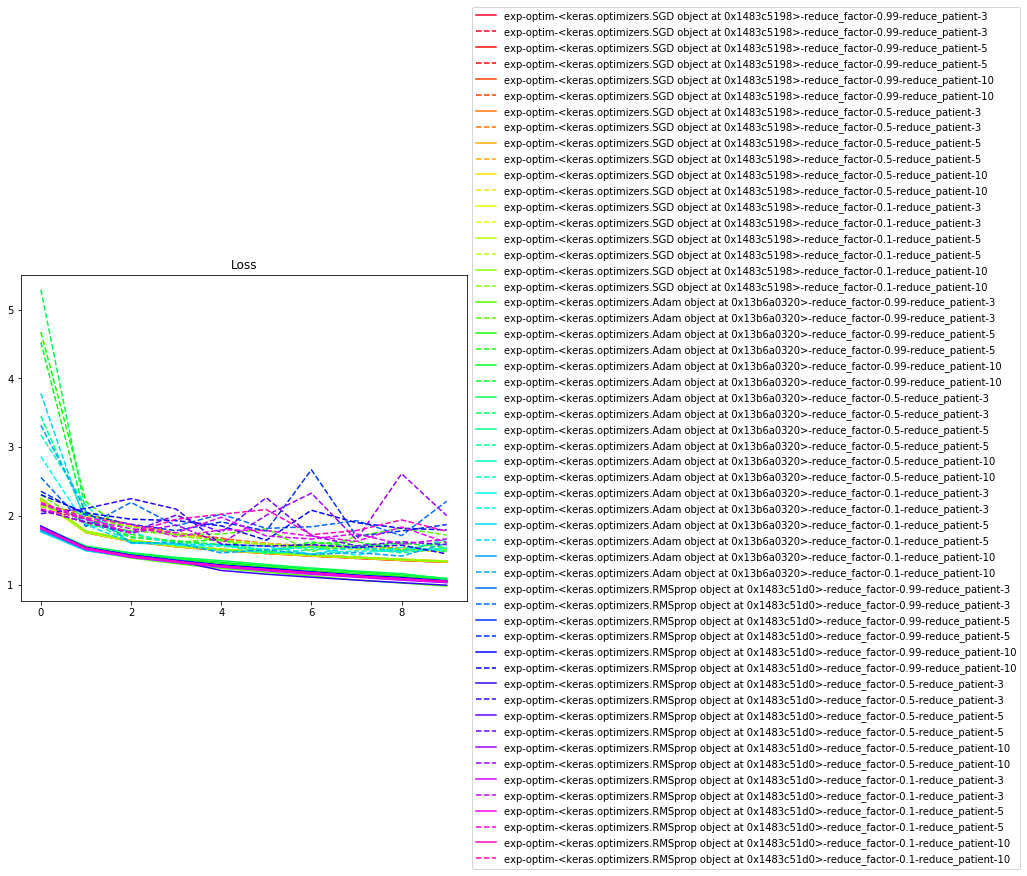

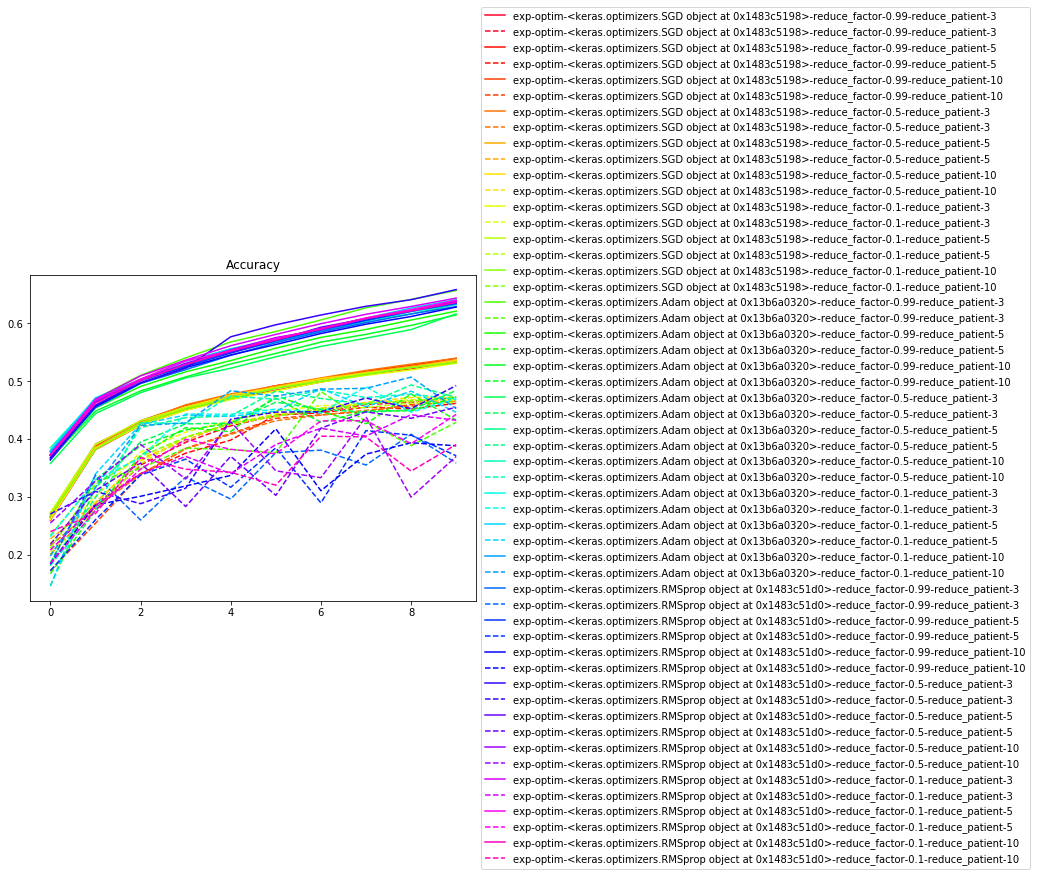

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()